In [1]:
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import spacy
from typing import List #Weil daraum 
import unidecode #PreProcessing
import re #Regular Expressions PreProcessing
import string
from collections import Counter 

from spacy.tokenizer import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer #TFIDF
from sklearn.feature_extraction.text import CountVectorizer #Document Word Matrix
from sklearn.model_selection import train_test_split, GridSearchCV  #Split in Trainings und Test Datensatz 
from sklearn.naive_bayes import MultinomialNB #MULTINOMIAL NAIVE BAYES CLASSIFIER
from sklearn.naive_bayes import ComplementNB #COMPLETE NAIVE BAYES 
from sklearn.svm import SVC #SUPPORT VECTOR MACHINES
from sklearn.linear_model import LogisticRegression 
import nltk 
from nltk.corpus import stopwords 

from sklearn import metrics 
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score #BEWERTUNG


2023-07-20 01:51:26.334020: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-20 01:51:26.374197: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-20 01:51:27.146342: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def tokenizer(text):  
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_space]
    return tokens

In [3]:
#CLEANING

def convert_to_lowercase(text: str) -> str:
    return text.lower()

def regex(text: str) -> str:
   
    text = re.sub(r'\S*@\S*\s?', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\'", '', text)
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\b\w\b', '', text)
    hashtags = re.findall(r'#\w+', text)
    text += ' '.join(hashtags)   
    return text

def lemmatize(text: str) -> str:
    # Lemmatisierung mit SpaCy
    doc = nlp(text)
    lemmatized_words = []
    for token in doc:
        lemmatized_words.append(token.lemma_)
    
    return " ".join(lemmatized_words)


def remove_stopwords(text: str, sw: List[str] = stopwords.words("english")) -> str: 
    #Eventuell überarbeiten
    additional_sw = ["ubers","uber","drive","gt","get","got","go","ride","make","would","say","driver", "nt", "ca"]
    sw = sw + additional_sw
    text_list = text.split()
    text_list = [word for word in text_list if word.lower() not in sw]
    return " ".join(text_list)

def remove_punctuation(text: str, punct: str = string.punctuation) -> str:
   
    cleaned_text = "".join([char for char in text if char not in punct])
    return cleaned_text

def unicode(text: str) -> str:
    return unidecode.unidecode(text)

def clean(text: str) -> str:
    text = regex(text)
    text = unicode(text)
    text = remove_punctuation(text)
    text = convert_to_lowercase(text)
    text = lemmatize(text)
    text = remove_stopwords(text)
    return text

In [4]:
#setup 
nltk.download("stopwords")
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/michael/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
dataset = load_dataset("sst2")
train_data = dataset["train"]
X_train, X_test, Y_train, Y_test = train_test_split(train_data['sentence'], train_data['label'], test_size=0.2, random_state=42)

Found cached dataset sst2 (/home/michael/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
train_df = pd.DataFrame({'sentence': X_train, 'label': Y_train})
test_df = pd.DataFrame({'sentence': X_test, 'label': Y_test})

In [109]:
zero_count = train_df["label"].value_counts()[0]
print("Anzahl der Nullen in der Spalte 'label':", zero_count)

Anzahl der Nullen in der Spalte 'label': 23871


In [107]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53879 entries, 0 to 53878
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  53879 non-null  object
 1   label     53879 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 842.0+ KB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13470 entries, 0 to 13469
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  13470 non-null  object
 1   label     13470 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 210.6+ KB


In [9]:
train_df["sentence"] = train_df["sentence"].astype(str).apply(lambda x : clean(x))
test_df["sentence"] = test_df["sentence"].astype(str).apply(lambda x : clean(x))

In [10]:
#Feature Repräsentation TermFreq

def TermFreq(train_data, test_data, ngram_range=(1, 1)):
    
    vectorizer = CountVectorizer(stop_words='english',ngram_range=ngram_range, tokenizer=tokenizer, preprocessor=clean)

    X_train = vectorizer.fit_transform(train_data['sentence'])
    Y_train = train_data['label']

    X_test = vectorizer.transform(test_data['sentence'])
    Y_test = test_data['label']

    return X_train, Y_train, X_test, Y_test, vectorizer

In [11]:
def tfidf(train_data, test_data, ngram_range=(1,1)):
    
    tfidf = TfidfVectorizer(ngram_range=ngram_range,preprocessor=clean, tokenizer=tokenizer)

    X_train = tfidf.fit_transform(train_data['sentence'])
    Y_train = train_data['label']

    X_test = tfidf.transform(test_data['sentence'])
    Y_test = test_data['label']

    return X_train, Y_train, X_test, Y_test, tfidf

In [12]:
def mnb_tuning( X_test, Y_test, X_train, Y_train):
    # Multinomialer Naive Bayes Classifier
    MNB = MultinomialNB()

    # Hyperparameter für Grid Search
    parameters = {'alpha': np.logspace(-4, 4, 20)}

    # Grid Search mit 5-facher Kreuzvalidierung
    grid_search = GridSearchCV(MNB, parameters, cv=10, scoring="accuracy", verbose=2, refit=True, n_jobs = -1)
    grid_search.fit(X_train, Y_train)
    print(grid_search.best_score_)
    best_params = grid_search.best_params_  # Beste Hyperparameter-Kombination
    best_model = grid_search.best_estimator_  # Bestes Modell
    
    #results = pd.DataFrame(grid_search.cv_results_)
    #print(results)
    # Ausgabe der Ergebnisse
    print("Beste Hyperparameter: ", best_params)
    results = grid_search.cv_results_
    # Metriken berechnen
    Y_pred = best_model.predict(X_test)
    report = classification_report(Y_test, Y_pred, digits=4)
    print(report)
    
    return best_model, results

In [198]:
def svc_tuning(X_test, Y_test, X_train, Y_train):

    svc = SVC()
    
    parameters = {'kernel': ['linear'], 
                  'C': np.logspace(-3, 3, 10), 
                  }
    
    grid_search = GridSearchCV(svc, parameters, cv=10, scoring="accuracy", verbose=3, refit=True, n_jobs = -1)
    grid_search.fit(X_train, Y_train)
    
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    results = grid_search.cv_results_
    print("Beste Hyperparameter: ", best_params)

    # Metriken berechnen
    Y_pred = best_model.predict(X_test)
    report = classification_report(Y_test, Y_pred, digits=4)
    print(report)

    return best_model, results 

In [14]:
def logreg_tuning(X_test, Y_test, X_train, Y_train):

    lr = LogisticRegression(max_iter=100000000000000)
    
    parameters = {
    'C': np.logspace(-3, 3, 10),  
    'penalty': ['l2'], # Beispielhafte Werte für den Strafterm (Penalty)
    'solver'  : ["lbfgs", "newton-cg"],
    }
    
    grid_search = GridSearchCV(lr, parameters, cv=10, scoring="accuracy", refit=True, verbose=2, n_jobs = -1)
    grid_search.fit(X_train, Y_train)
    results = grid_search.cv_results_
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    print("Beste Hyperparameter: ", best_params)

    # Metriken berechnen
    Y_pred = best_model.predict(X_test)
    report = classification_report(Y_test, Y_pred, digits=4)
    print(report)
    
    return best_model, results

In [15]:
#UNIGRAM TermFreq
X_train, Y_train, X_test, Y_test, uni_tf = TermFreq(train_df, test_df, ngram_range=(1, 1))


/home/michael/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/michael/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'whereaft'] not in stop_words.
  warnings.warn(


In [16]:
lr_uni_tf, r1 = logreg_tuning(X_test, Y_test, X_train, Y_train)
svc_uni_tf, r2 = svc_tuning(X_test, Y_test, X_train, Y_train)
mnb_uni_tf, r3 = mnb_tuning(X_test, Y_test, X_train, Y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Beste Hyperparameter:  {'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'}
              precision    recall  f1-score   support

           0     0.8806    0.8584    0.8693      5909
           1     0.8914    0.9090    0.9001      7561

    accuracy                         0.8868     13470
   macro avg     0.8860    0.8837    0.8847     13470
weighted avg     0.8867    0.8868    0.8866     13470

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] END ..................C=0.001, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ...C=0.004641588833612777, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ...C=0.004641588833612777, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END C=0.004641588833612777, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END ...C=0.021544346900318832, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END C=0.021544346900318832, penalty=l2, solver=newton-cg; total

In [18]:
import pickle
with open('uni_tf.pkl', 'wb') as file:
    pickle.dump(uni_tf, file)

In [19]:
#UNIGRAM / BIGRAM  TermFreq
X_train, Y_train, X_test, Y_test, unibi_tf = TermFreq(train_df, test_df, ngram_range=(1, 2))
lr_uni_bi__tf, r4 = logreg_tuning(X_test, Y_test, X_train, Y_train)
svc_uni_bi__tf, r5 = svc_tuning(X_test, Y_test, X_train, Y_train)
mnb_uni_bi__tf, r6 = mnb_tuning(X_test, Y_test, X_train, Y_train)

/home/michael/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/michael/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'whereaft'] not in stop_words.
  warnings.warn(


Fitting 10 folds for each of 20 candidates, totalling 200 fits
Beste Hyperparameter:  {'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0     0.9099    0.8848    0.8971      5909
           1     0.9118    0.9315    0.9216      7561

    accuracy                         0.9110     13470
   macro avg     0.9108    0.9081    0.9093     13470
weighted avg     0.9110    0.9110    0.9108     13470

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] END ..................C=0.001, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END ...C=0.004641588833612777, penalty=l2, solver=lbfgs; total time=   0.5s
[CV] END C=0.004641588833612777, penalty=l2, solver=newton-cg; total time=   0.9s
[CV] END ...C=0.021544346900318832, penalty=l2, solver=lbfgs; total time=   0.9s
[CV] END C=0.021544346900318832, penalty=l2, solver=newton-cg; total time=   1.2s
[CV] END C=0.09999999999999999, penalty=l2, solver=newton-cg; total tim

In [24]:
with open('unibi_tf.pkl', 'wb') as file:
    pickle.dump(unibi_tf, file)


In [25]:
#BIGRAM TermFreq
X_train3, Y_train3, X_test3, Y_test3, bi_tf = TermFreq(train_df, test_df, ngram_range=(2, 2))


In [26]:
lr_bi_tf, r7 = logreg_tuning(X_test3, Y_test3, X_train3, Y_train3)
svc_bi_tf2, r8 = svc_tuning(X_test3, Y_test3, X_train3, Y_train3)
mnb_bi_tf, r9 = mnb_tuning(X_test3, Y_test3, X_train3, Y_train3)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Beste Hyperparameter:  {'C': 46.41588833612773, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0     0.9088    0.7522    0.8231      5909
           1     0.8294    0.9410    0.8817      7561

    accuracy                         0.8582     13470
   macro avg     0.8691    0.8466    0.8524     13470
weighted avg     0.8642    0.8582    0.8560     13470

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] END ..................C=0.001, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ..............C=0.001, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ..............C=0.001, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ..............C=0.001, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ...C=0.004641588833612777, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END C=0.004641588833612777, penalty=l2, solver=newton-c

In [201]:
svc_bi_tf2, r8 = svc_tuning(X_test3, Y_test3, X_train3, Y_train3)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 7/10] END ...........C=0.001, kernel=linear;, score=0.557 total time= 3.0min
[CV 10/10] END C=0.004641588833612777, kernel=linear;, score=0.557 total time= 2.6min
[CV 8/10] END C=0.021544346900318832, kernel=linear;, score=0.598 total time= 2.5min
[CV 8/10] END C=0.09999999999999999, kernel=linear;, score=0.755 total time= 3.7min
[CV 2/10] END C=2.154434690031882, kernel=linear;, score=0.854 total time= 7.3min
[CV 4/10] END ............C=10.0, kernel=linear;, score=0.842 total time= 6.7min
[CV 8/10] END C=46.41588833612773, kernel=linear;, score=0.820 total time= 3.7min
[CV 9/10] END C=215.44346900318823, kernel=linear;, score=0.839 total time= 4.7min
[CV 10/10] END ..........C=0.001, kernel=linear;, score=0.557 total time= 2.5min
[CV 3/10] END C=0.004641588833612777, kernel=linear;, score=0.557 total time= 2.7min
[CV 5/10] END C=0.021544346900318832, kernel=linear;, score=0.598 total time= 3.1min
[CV 10/10] END C=0.099

In [27]:
with open('bi_tf.pkl', 'wb') as file:
    pickle.dump(bi_tf, file)


In [28]:
#UNIGRAM TFIDF
X_train4, Y_train4, X_test4, Y_test4, uni_tfidf = tfidf(train_df, test_df, ngram_range=(1, 1))

/home/michael/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ..................C=0.001, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ...C=0.004641588833612777, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ...C=0.021544346900318832, penalty=l2, solver=lbfgs; total time=   0.7s
[CV] END C=0.021544346900318832, penalty=l2, solver=newton-cg; total time=   0.5s
[CV] END C=0.09999999999999999, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.09999999999999999, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END .....C=0.4641588833612777, penalty=l2, solver=lbfgs; total time=   1.4s
[CV] END .C=0.4641588833612777, penalty=l2, solver=newton-cg; total time=   0.7s
[CV] END ......C=2.154434690031882, penalty=l2, solver=lbfgs; total time=   1.9s
[CV] END ..C=2.154434690031882, penalty=l2, solver=newton-cg; total time=   0.7s
[CV] END ...................C=10.0, penalty=l2, solver=lbfgs; total time=   5.8s
[CV] END ......C=46.41588833612773, penalty=l2, solver=lbfgs; total time=   7.2s
[CV] END ..C=46.41588833612

In [29]:
lr_uni_tfidf, r10 = logreg_tuning(X_test4, Y_test4, X_train4, Y_train4)
svc_uni_tfidf, r11 = svc_tuning(X_test4, Y_test4, X_train4, Y_train4)
mnb_uni_tfidf, r12 = mnb_tuning(X_test4, Y_test4, X_train4, Y_train4)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Beste Hyperparameter:  {'C': 46.41588833612773, 'penalty': 'l2', 'solver': 'newton-cg'}
              precision    recall  f1-score   support

           0     0.8795    0.8744    0.8770      5909
           1     0.9023    0.9064    0.9043      7561

    accuracy                         0.8924     13470
   macro avg     0.8909    0.8904    0.8906     13470
weighted avg     0.8923    0.8924    0.8923     13470

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] END ..................C=0.001, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ...C=0.004641588833612777, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END C=0.004641588833612777, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END ...C=0.021544346900318832, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END C=0.021544346900318832, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END ....C=0.09999999999999999, penalty=l2, solver

In [30]:
with open('uni_tfidf.pkl', 'wb') as file:
    pickle.dump(uni_tfidf, file)


In [31]:
#UNIGRAM / BIGRAM TFIDF
X_train5, Y_train5, X_test5, Y_test5, unibi_tfidf = tfidf(train_df, test_df, ngram_range=(1, 2))

/home/michael/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ........................alpha=9.999999999999999e-05; total time=   0.0s
[CV] END ..........................alpha=0.08858667904100824; total time=   0.0s
[CV] END ..........................alpha=0.08858667904100824; total time=   0.0s
[CV] END ............................alpha=0.615848211066026; total time=   0.0s
[CV] END ............................alpha=0.615848211066026; total time=   0.0s
[CV] END ............................alpha=29.76351441631313; total time=   0.0s
[CV] END ............................alpha=29.76351441631313; total time=   0.0s
[CV] END ............................alpha=29.76351441631313; total time=   0.0s
[CV] END ............................alpha=29.76351441631313; total time=   0.0s
[CV] END ............................alpha=545.5594781168514; total time=   0.0s
[CV] END ...........................alpha=1438.4498882876599; total time=   0.0s
[CV] END ............................alpha=3792.690190732246; total time=   0.0s
[CV] END ...................

In [32]:
lr_uni_bi_tfidf, r13 = logreg_tuning(X_test5, Y_test5, X_train5, Y_train5)
svc_uni_bi_tfidf, r14 = svc_tuning(X_test5, Y_test5, X_train5, Y_train5)
mnb_uni_bi_tfidf, r15 = mnb_tuning(X_test5, Y_test5, X_train5, Y_train5)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Beste Hyperparameter:  {'C': 46.41588833612773, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0     0.9046    0.9079    0.9062      5909
           1     0.9278    0.9251    0.9265      7561

    accuracy                         0.9176     13470
   macro avg     0.9162    0.9165    0.9164     13470
weighted avg     0.9176    0.9176    0.9176     13470

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] END ..............C=0.001, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.004641588833612777, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END ...C=0.021544346900318832, penalty=l2, solver=lbfgs; total time=   0.9s
[CV] END ....C=0.09999999999999999, penalty=l2, solver=lbfgs; total time=   1.5s
[CV] END .....C=0.4641588833612777, penalty=l2, solver=lbfgs; total time=   1.6s
[CV] END .C=0.4641588833612777, penalty=l2, solver=newton-c

In [188]:
svc_uni_bi_tfidf2, r_20 = svc_tuning(X_test5, Y_test5, X_train5, Y_train5)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 7/10] END ...........C=0.001, kernel=linear;, score=0.557 total time=33.6min
[CV 1/10] END C=0.021544346900318832, kernel=linear;, score=0.571 total time=32.8min
[CV 2/10] END C=0.09999999999999999, kernel=linear;, score=0.846 total time=33.8min
[CV 4/10] END C=0.4641588833612777, kernel=linear;, score=0.900 total time=37.0min
[CV 4/10] END C=2.154434690031882, kernel=linear;, score=0.912 total time=62.6min
[CV 7/10] END ............C=10.0, kernel=linear;, score=0.914 total time=69.5min
[CV 6/10] END C=46.41588833612773, kernel=linear;, score=0.909 total time=85.8min
[CV 9/10] END C=215.44346900318823, kernel=linear;, score=0.914 total time=82.3min
[CV 10/10] END ..........C=0.001, kernel=linear;, score=0.557 total time=31.7min
[CV 4/10] END C=0.004641588833612777, kernel=linear;, score=0.557 total time=33.1min
[CV 6/10] END C=0.021544346900318832, kernel=linear;, score=0.571 total time=32.1min
[CV 8/10] END C=0.0999999

In [200]:
X_trainJ, Y_trainJ, X_testJ, Y_testJ, unibi_tf = TermFreq(train_df, test_df, ngram_range=(1, 2))
svc_uni_bi_tf2, r_21 = svc_tuning(X_testJ, Y_testJ, X_trainJ, Y_trainJ)

/home/michael/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/michael/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'whereaft'] not in stop_words.
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 8/10] END ...........C=0.001, kernel=linear;, score=0.563 total time= 4.3min
[CV 6/10] END C=0.004641588833612777, kernel=linear;, score=0.655 total time= 4.3min
[CV 6/10] END C=0.021544346900318832, kernel=linear;, score=0.808 total time= 3.7min
[CV 7/10] END C=0.09999999999999999, kernel=linear;, score=0.880 total time= 5.5min
[CV 10/10] END C=0.4641588833612777, kernel=linear;, score=0.905 total time=10.6min
[CV 2/10] END ............C=10.0, kernel=linear;, score=0.897 total time=15.3min
[CV 6/10] END C=46.41588833612773, kernel=linear;, score=0.887 total time=14.2min
[CV 1/10] END ..........C=1000.0, kernel=linear;, score=0.883 total time=12.6min
[CV 7/10] END ...........C=0.001, kernel=linear;, score=0.564 total time= 4.2min
[CV 4/10] END C=0.004641588833612777, kernel=linear;, score=0.654 total time= 4.8min
[CV 8/10] END C=0.021544346900318832, kernel=linear;, score=0.801 total time= 5.3min
[CV 1/10] END C=0.46415

In [34]:
with open('unibi_tfidf.pkl', 'wb') as file:
    pickle.dump(unibi_tfidf, file)


In [35]:
#BIGRAM TFIDF
X_train6, Y_train6, X_test6, Y_test6, bi_tfidf = tfidf(train_df, test_df, ngram_range=(2, 2))

/home/michael/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ........................alpha=9.999999999999999e-05; total time=   0.0s
[CV] END ........................alpha=0.0002636650898730358; total time=   0.0s
[CV] END ........................alpha=0.0002636650898730358; total time=   0.0s
[CV] END ........................alpha=0.0002636650898730358; total time=   0.0s
[CV] END ........................alpha=0.0002636650898730358; total time=   0.0s
[CV] END ........................alpha=0.0002636650898730358; total time=   0.0s
[CV] END ........................alpha=0.0002636650898730358; total time=   0.0s
[CV] END ........................alpha=0.0002636650898730358; total time=   0.0s
[CV] END ........................alpha=0.0002636650898730358; total time=   0.0s
[CV] END ........................alpha=0.0006951927961775606; total time=   0.0s
[CV] END ........................alpha=0.0006951927961775606; total time=   0.0s
[CV] END ........................alpha=0.0006951927961775606; total time=   0.0s
[CV] END ...................

In [44]:
lr_bi_tfidf, r16 = logreg_tuning(X_test6, Y_test6, X_train6, Y_train6)
svc_bi_tfidf, r17 = svc_tuning(X_test6, Y_test6, X_train6, Y_train6)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Beste Hyperparameter:  {'C': 46.41588833612773, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0     0.9005    0.7839    0.8381      5909
           1     0.8466    0.9323    0.8874      7561

    accuracy                         0.8672     13470
   macro avg     0.8735    0.8581    0.8628     13470
weighted avg     0.8702    0.8672    0.8658     13470

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] END ..................C=0.001, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END ...C=0.004641588833612777, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END ...C=0.021544346900318832, penalty=l2, solver=lbfgs; total time=   0.5s
[CV] END C=0.021544346900318832, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END ....C=0.09999999999999999, penalty=l2, solver=lbfgs; total time=   0.7s
[CV] END .....C=0.4641588833612777, penalty=l2, solver=lbfg

In [39]:
mnb_bi_tfidf, r18 = mnb_tuning(X_test6, Y_test6, X_train6, Y_train6)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
0.8544330166563101
Beste Hyperparameter:  {'alpha': 0.033598182862837805}
              precision    recall  f1-score   support

           0     0.8770    0.7744    0.8225      5909
           1     0.8385    0.9151    0.8751      7561

    accuracy                         0.8534     13470
   macro avg     0.8577    0.8448    0.8488     13470
weighted avg     0.8554    0.8534    0.8520     13470



In [37]:
with open('bi_tfidf.pkl', 'wb') as file:
    pickle.dump(bi_tfidf, file)


In [191]:
df_r1 = pd.DataFrame(r1)
df_r2 = pd.DataFrame(r2)
df_r3 = pd.DataFrame(r3)
df_r4 = pd.DataFrame(r4)
df_r5 = pd.DataFrame(r5)
df_r6 = pd.DataFrame(r6)
df_r7 = pd.DataFrame(r7)
df_r8 = pd.DataFrame(r8)
df_r9 = pd.DataFrame(r9)
df_r10 = pd.DataFrame(r10)
df_r11 = pd.DataFrame(r11)
df_r12 = pd.DataFrame(r12)
df_r13 = pd.DataFrame(r13)
df_r14 = pd.DataFrame(r14)
df_r15 = pd.DataFrame(r15)
df_r16 = pd.DataFrame(r16)
df_r17 = pd.DataFrame(r17)
df_r18 = pd.DataFrame(r18)
df_r20 = pd.DataFrame(r_20)

In [192]:
df_r1.to_csv("GridSearch/r1.csv")
df_r2.to_csv("GridSearch/r2.csv")
df_r3.to_csv("GridSearch/r3.csv")
df_r4.to_csv("GridSearch/r4.csv")
df_r5.to_csv("GridSearch/r5.csv")
df_r6.to_csv("GridSearch/r6.csv")
df_r7.to_csv("GridSearch/r7.csv")
df_r8.to_csv("GridSearch/r8.csv")
df_r9.to_csv("GridSearch/r9.csv")
df_r10.to_csv("GridSearch/r10.csv")
df_r11.to_csv("GridSearch/r11.csv")
df_r12.to_csv("GridSearch/r12.csv")
df_r13.to_csv("GridSearch/r13.csv")
df_r14.to_csv("GridSearch/r14.csv")
df_r15.to_csv("GridSearch/r15.csv")
df_r16.to_csv("GridSearch/r16.csv")
df_r17.to_csv("GridSearch/r17.csv")
df_r18.to_csv("GridSearch/r18.csv")
df_r20.to_csv("GridSearch/r20.csv")

In [46]:
kaggle_df = pd.read_csv("Reddit_Data_kaggle.csv")
kaggle_df["clean_comment"] = kaggle_df["clean_comment"].astype(str).apply(lambda x : clean(x))
kaggle_df = kaggle_df[kaggle_df['category'] != 0]
kaggle_df['category'] = kaggle_df['category'].replace(-1, 0)
kaggle_df.head()

,clean_comment,category
0,family mormon never try explain still stare pu...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously thing first win complex explain norm...,0
4,benefit may want read living buddha live chris...,1
5,sit together watch simpson episode lisa become...,0


In [47]:
X_test = unibi_tfidf.transform(kaggle_df["clean_comment"])
Y_test = mnb_uni_bi_tfidf.predict(X_test)

In [48]:
print(accuracy_score(Y_test, kaggle_df["category"]))

0.6408926867714771


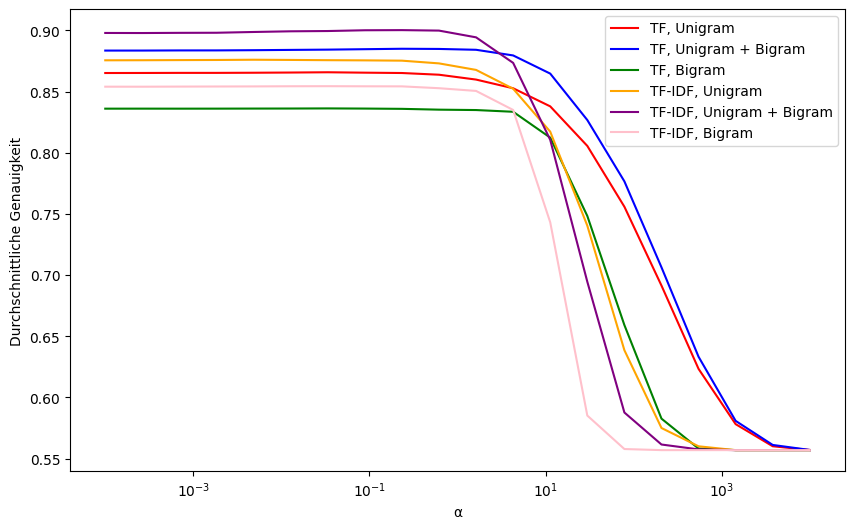

In [81]:
import matplotlib.pyplot as plt

# Ihre Datenframes (Annahme: df1, df2, ..., df6)
dataframes = [df_r3, df_r6, df_r9, df_r12, df_r15, df_r18]

# Farben für die Linien
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink']

# Liniendiagramm erstellen
plt.figure(figsize=(10, 6))  # Größe des Diagramms anpassen

for i, df in enumerate(dataframes):
    # X- und Y-Werte aus dem Dataframe extrahieren
    x_values = df['param_alpha']  # anpassen Sie den Spaltennamen entsprechend Ihrer Daten
    y_values = df['mean_test_score']  # anpassen Sie den Spaltennamen entsprechend Ihrer Daten

    # Linie für das aktuelle Modell zeichnen
    plt.plot(x_values, y_values, color=colors[i], label=f'Modell {i+1}')
alpha_symbol = '\u03B1'
custom_labels = ['TF, Unigram', 'TF, Unigram + Bigram', "TF, Bigram", "TF-IDF, Unigram", "TF-IDF, Unigram + Bigram", "TF-IDF, Bigram"]
plt.legend(custom_labels)
plt.xlabel(f'{alpha_symbol}')  # anpassen Sie die Achsenbeschriftung entsprechend Ihrer Daten
plt.ylabel('Durchschnittliche Genauigkeit')  # anpassen Sie die Achsenbeschriftung entsprechend Ihrer Daten
plt.xscale('log')
plt.savefig("MNB.png")
plt.show()  # Diagramm anzeigen


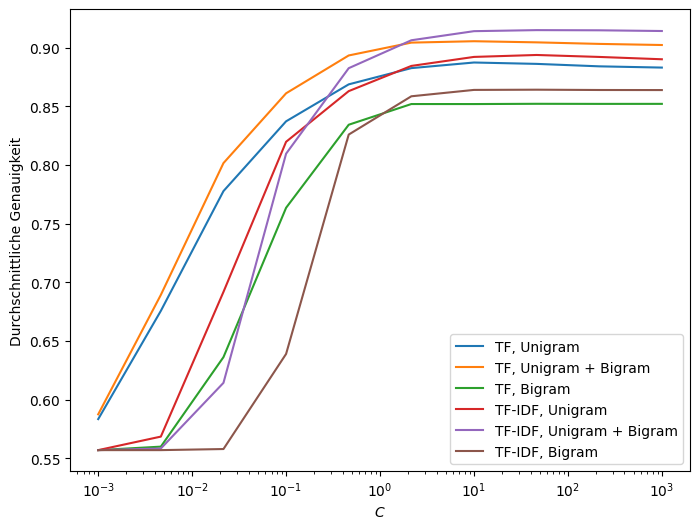

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Annahme: Du hast die Ergebnisse der sechs Modelle in einer Liste von DataFrames gespeichert.
# Beispielhafte Daten
dataframes = [df_r1, df_r4, df_r7, df_r10, df_r13, df_r16]  # Ersetze dies durch die tatsächlichen DataFrames

solver = 'lbfgs'
df_lbfgs = [df[df['param_solver'] == solver] for df in dataframes]

# C-Werte und Durchschnittliche Test Scores für den 'lbfgs'-Solver
c_values_lbfgs = [df['param_C'] for df in df_lbfgs]
test_scores_lbfgs = [df['mean_test_score'] for df in df_lbfgs]

# Plot erstellen
plt.figure(figsize=(8, 6))

# Linie für jedes Modell zeichnen
for i, (c_values, test_scores) in enumerate(zip(c_values_lbfgs, test_scores_lbfgs)):
    plt.plot(c_values, test_scores, label=f'Modell {i+1}')

custom_labels = ['TF, Unigram', 'TF, Unigram + Bigram', "TF, Bigram", "TF-IDF, Unigram", "TF-IDF, Unigram + Bigram", "TF-IDF, Bigram"]
# Achsentitel und Titel hinzufügen
plt.xlabel('$C$')
plt.ylabel('Durchschnittliche Genauigkeit')
plt.xscale('log')  # logarithmische Skala auf der X-Achse verwenden, um C-Werte besser darzustellen
plt.legend(custom_labels)
plt.savefig("LR.png")
# Diagramm anzeigen
plt.show()


In [65]:
df_r1.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.085186,0.013728,0.001960,0.000480,0.001,l2,lbfgs,"{'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}",0.582777,0.585375,...,0.585375,0.585375,0.581292,0.583890,0.583519,0.583333,0.578801,0.583400,0.001967,19
1,0.239850,0.037174,0.001970,0.000519,0.001,l2,newton-cg,"{'C': 0.001, 'penalty': 'l2', 'solver': 'newto...",0.582777,0.585375,...,0.585375,0.585375,0.581292,0.583890,0.583519,0.583333,0.578801,0.583400,0.001967,19
2,0.117782,0.019319,0.001990,0.000368,0.004642,l2,lbfgs,"{'C': 0.004641588833612777, 'penalty': 'l2', '...",0.679287,0.679102,...,0.677617,0.674462,0.674091,0.669822,0.664811,0.679844,0.673659,0.675699,0.005298,17
3,0.310746,0.041437,0.002233,0.000350,0.004642,l2,newton-cg,"{'C': 0.004641588833612777, 'penalty': 'l2', '...",0.679287,0.679102,...,0.677617,0.674462,0.674091,0.669822,0.664625,0.679844,0.673659,0.675681,0.005336,18
4,0.215825,0.036972,0.002134,0.000425,0.021544,l2,lbfgs,"{'C': 0.021544346900318832, 'penalty': 'l2', '...",0.778768,0.782851,...,0.781180,0.779881,0.780809,0.774128,0.766704,0.771901,0.776128,0.777835,0.005411,16


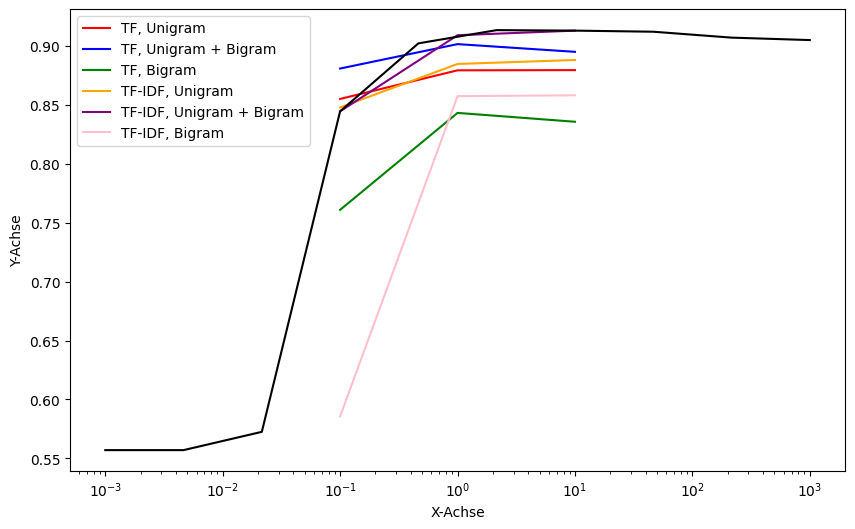

In [197]:
import matplotlib.pyplot as plt

# Ihre Datenframes (Annahme: df1, df2, ..., df6)
dataframes = [df_r2, df_r5, df_r8, df_r11, df_r14, df_r17, df_r20]

# Farben für die Linien
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', "black"]

# Liniendiagramm erstellen
plt.figure(figsize=(10, 6))  # Größe des Diagramms anpassen

for i, df in enumerate(dataframes):
    # X- und Y-Werte aus dem Dataframe extrahieren
    x_values = df['param_C']  # anpassen Sie den Spaltennamen entsprechend Ihrer Daten
    y_values = df['mean_test_score']  # anpassen Sie den Spaltennamen entsprechend Ihrer Daten

    # Linie für das aktuelle Modell zeichnen
    plt.plot(x_values, y_values, color=colors[i], label=f'Modell {i+1}')

custom_labels = ['TF, Unigram', 'TF, Unigram + Bigram', "TF, Bigram", "TF-IDF, Unigram", "TF-IDF, Unigram + Bigram", "TF-IDF, Bigram"]
plt.legend(custom_labels)
plt.xlabel('X-Achse')  # anpassen Sie die Achsenbeschriftung entsprechend Ihrer Daten
plt.ylabel('Y-Achse')  # anpassen Sie die Achsenbeschriftung entsprechend Ihrer Daten
plt.xscale('log')
plt.savefig("SVC.png")
plt.show()  # Diagramm anzeigen

In [112]:
y_pred = mnb_uni_bi_tfidf.predict(X_test5)

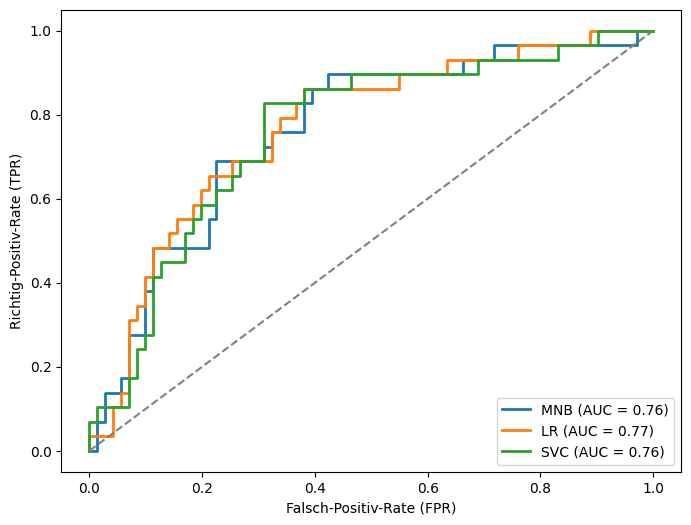

In [202]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

Y_test = df_reddit["Sentiment"]

# Angenommen, Sie haben drei Klassifikatoren mnb_uni_bi_tfidf, lr und svc, und Sie haben ihre Vorhersagen für die Testdaten bereits erhalten.

# Liste der Klassifikatoren und ihre entsprechenden Namen
classifiers = [mnb_uni_bi_tfidf, lr_uni_bi_tfidf, svc_uni_bi_tfidf2]
classifier_names = ['MNB', 'LR', 'SVC']

# Liste für die ROC-Kurve, TPR, FPR und AUC für jeden Klassifikator
roc_curves = []
tprs = []
fprs = []
auc_scores = []

# Plot der ROC-Kurve für jeden Klassifikator
plt.figure(figsize=(8, 6))
for classifier, name in zip(classifiers, classifier_names):
    y_pred_prob = classifier.predict_proba(X_test_reddit)
    fpr, tpr, _ = roc_curve(Y_test.values.ravel(), y_pred_prob[:, 1])  # Angenommen, 1 ist der Index der positiven Klasse
    roc_auc = auc(fpr, tpr)

    roc_curves.append((fpr, tpr))
    tprs.append(tpr)
    fprs.append(fpr)
    auc_scores.append(roc_auc)

    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Falsch-Positiv-Rate (FPR)')
plt.ylabel('Richtig-Positiv-Rate (TPR)')
plt.legend(loc='lower right')
plt.savefig("roc.png")
plt.show()

In [93]:
df_reddit = pd.read_csv("rated_selftext_v2.csv", delimiter = ";")
df_reddit["selftext"] = df_reddit["selftext"].astype(str).apply(lambda x : clean(x))
df_reddit = df_reddit[df_reddit['Sentiment'] != 0]
df_reddit['Sentiment'] = df_reddit['Sentiment'].replace(-1, 0)
df_reddit.head()
len(df_reddit)

100

In [94]:
X_test_reddit = unibi_tfidf.transform(df_reddit["selftext"])

In [97]:
Y_pred_reddit_mnb = mnb_uni_bi_tfidf.predict(X_test_reddit)
print(accuracy_score(Y_pred_reddit_mnb, df_reddit["Sentiment"]))

0.72


In [98]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df_reddit["Sentiment"], Y_pred_reddit_mnb)
print(classification_report(df_reddit["Sentiment"], Y_pred_reddit_mnb, digits=4))
print("Confusion Matrix:")
print(cm)


              precision    recall  f1-score   support

           0     0.8209    0.7746    0.7971        71
           1     0.5152    0.5862    0.5484        29

    accuracy                         0.7200       100
   macro avg     0.6680    0.6804    0.6727       100
weighted avg     0.7322    0.7200    0.7250       100

Confusion Matrix:
[[55 16]
 [12 17]]


In [103]:
Y_pred_reddit_lr = lr_uni_bi_tfidf.predict(X_test_reddit)
print(accuracy_score(Y_pred_reddit_lr, df_reddit["Sentiment"]))
cm = confusion_matrix(df_reddit["Sentiment"], Y_pred_reddit_lr)
print(classification_report(df_reddit["Sentiment"], Y_pred_reddit_lr, digits=4))
print("Confusion Matrix:")
print(cm)


0.69
              precision    recall  f1-score   support

           0     0.8448    0.6901    0.7597        71
           1     0.4762    0.6897    0.5634        29

    accuracy                         0.6900       100
   macro avg     0.6605    0.6899    0.6615       100
weighted avg     0.7379    0.6900    0.7028       100

Confusion Matrix:
[[49 22]
 [ 9 20]]


In [203]:
Y_pred_reddit_svc = svc_uni_bi_tfidf2.predict(X_test_reddit)
print(accuracy_score(Y_pred_reddit_svc, df_reddit["Sentiment"]))
cm = confusion_matrix(df_reddit["Sentiment"], Y_pred_reddit_svc)
print(classification_report(df_reddit["Sentiment"], Y_pred_reddit_svc, digits=4))
print("Confusion Matrix:")
print(cm)

0.73
              precision    recall  f1-score   support

           0     0.9074    0.6901    0.7840        71
           1     0.5217    0.8276    0.6400        29

    accuracy                         0.7300       100
   macro avg     0.7146    0.7589    0.7120       100
weighted avg     0.7956    0.7300    0.7422       100

Confusion Matrix:
[[49 22]
 [ 5 24]]


In [51]:
import pickle 
with open('lr_uni_tf.pkl', 'wb') as file:
    pickle.dump(lr_uni_tf, file)

with open('svc_uni_tf.pkl', 'wb') as file:
    pickle.dump(svc_uni_tf, file)

with open('mnb_uni_tf.pkl', 'wb') as file:
    pickle.dump(mnb_uni_tf, file)

    

with open('lr_uni_bi__tf.pkl', 'wb') as file:
    pickle.dump(lr_uni_bi__tf, file)

with open('svc_uni_bi__tf.pkl', 'wb') as file:
    pickle.dump(svc_uni_bi__tf, file)

with open('mnb_uni_bi__tf.pkl', 'wb') as file:
    pickle.dump(mnb_uni_bi__tf, file)

    

with open('svc_bi_tf.pkl', 'wb') as file:
    pickle.dump(svc_bi_tf, file)

with open('lr_bi_tf.pkl', 'wb') as file:
    pickle.dump(lr_bi_tf, file)

with open('mnb_bi_tf.pkl', 'wb') as file:
    pickle.dump(mnb_bi_tf, file)

    

with open('svc_uni_tfidf.pkl', 'wb') as file:
    pickle.dump(svc_uni_tfidf, file)

with open('lr_uni_tfidf.pkl', 'wb') as file:
    pickle.dump(lr_uni_tfidf, file)

with open('mnb_uni_tfidf.pkl', 'wb') as file:
    pickle.dump(mnb_uni_tfidf, file)


with open('svc_uni_bi_tfidf.pkl', 'wb') as file:
    pickle.dump(svc_uni_bi_tfidf, file)

with open('lr_uni_bi_tfidf.pkl', 'wb') as file:
    pickle.dump(lr_uni_bi_tfidf, file)

with open('mnb_uni_bi_tfidf.pkl', 'wb') as file:
    pickle.dump(mnb_uni_bi_tfidf, file)


with open('svc_bi_tfidf.pkl', 'wb') as file:
    pickle.dump(svc_bi_tfidf, file)

with open('lr_bi_tfidf.pkl', 'wb') as file:
    pickle.dump(lr_bi_tfidf, file)

with open('mnb_bi_tfidf.pkl', 'wb') as file:
    pickle.dump(mnb_bi_tfidf, file)

In [ ]:
svc = SVC()
    
parameters = {'kernel': ['linear'], 
                  'C': np.logspace(-1, 3, 10), 
                  }
    
grid_search = GridSearchCV(svc, parameters, cv=10, scoring="accuracy", verbose=3, refit=True, n_jobs = -1)
grid_search.fit(X_train5, Y_train5)
    
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
results = grid_search.cv_results_
print("Beste Hyperparameter: ", best_params)

    # Metriken berechnen
Y_pred = best_model.predict(X_test5)
report = classification_report(Y_test5, Y_pred, digits=4)
print(report)

In [144]:
base_model = LogisticRegression()
base_model.fit(X_train5, Y_train5)
Y_pred_base = base_model.predict(X_test5)
print(accuracy_score(Y_test5, Y_pred_base))

0.9005939123979213


In [147]:
Y_pred_reddit_lr = base_model.predict(X_test_reddit)

In [148]:
print(accuracy_score(Y_pred_reddir_lr, reddit_df))

0.9005939123979213


In [182]:
all_dataframes = []

# Schleife über die 17 CSV-Dateien
for i in range(18):
    filename = f"results/{i}.csv"
    
    # Lese die CSV-Datei in ein DataFrame ein
    df = pd.read_csv(filename)
    
    # Füge das DataFrame zur Liste hinzu
    all_dataframes.append(df)

In [229]:
len(all_dataframes[2])

44831

In [183]:
laengen = []
for i in range(18):
    laengen.append(len(all_dataframes[i]))
    print(i)
print(sum(laengen))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
858146


In [184]:
laenge_rel = len(all_dataframes[0] + all_dataframes[3] + all_dataframes[4] + all_dataframes[5] + all_dataframes[10] + all_dataframes[14] + all_dataframes[15])
print(laenge_rel)

87039


In [185]:
print(laengen)

[58508, 39659, 44831, 47577, 58641, 15839, 27237, 40163, 23970, 32643, 87039, 83136, 40129, 21817, 43565, 68469, 47118, 77805]


In [207]:
X_0 = unibi_tfidf.transform(all_dataframes[0]["text"])
Y_0_S = svc_uni_bi_tfidf2.predict(X_0)

In [208]:
count_0 = 0
count_1 = 1

for element in Y_0_S:
    if element == 0:
        count_0 += 1
    elif element == 1:
        count_1 += 1



In [209]:
print(count_0)

29468


In [210]:
print(count_1)

29041


In [211]:
print(Y_0_S[:10])

[1 0 1 1 0 0 0 1 1 1]


In [212]:
print(all_dataframes[0]["text"][:10])

0    insurance issue definitely biggest gray area s...
1    seen hence started researching one hell gray a...
2    hadnt heard checked site independent taxi hire...
3    short explanation uberx ride sharing service c...
4    right mean couldnt still organize demands thre...
5    well thats really union trade organization sou...
6    well job construction concrete contractors tog...
7    definitely see point also lawyer pretty sure p...
8    gtthis job remember job partnered independent ...
9    personally fan unions join pay dues independen...
Name: text, dtype: object


In [213]:
X_2 = unibi_tfidf.transform(all_dataframes[2]["text"])
Y_2_S = svc_uni_bi_tfidf2.predict(X_2)
count_0 = 0
count_1 = 1

for element in Y_2_S:
    if element == 0:
        count_0 += 1
    elif element == 1:
        count_1 += 1

print(count_0)
print(count_1)

28182
16650


In [214]:
X_4 = unibi_tfidf.transform(all_dataframes[4]["text"])
Y_4_S = svc_uni_bi_tfidf2.predict(X_4)
count_0 = 0
count_1 = 1

for element in Y_4_S:
    if element == 0:
        count_0 += 1
    elif element == 1:
        count_1 += 1

print(count_0)
print(count_1)

32929
25713


In [215]:
X_8 = unibi_tfidf.transform(all_dataframes[8]["text"])
Y_8_S = svc_uni_bi_tfidf2.predict(X_8)
count_0 = 0
count_1 = 1

for element in Y_8_S:
    if element == 0:
        count_0 += 1
    elif element == 1:
        count_1 += 1

print(count_0)
print(count_1)

11961
12010


In [216]:
X_10 = unibi_tfidf.transform(all_dataframes[10]["text"])
Y_10_S = svc_uni_bi_tfidf2.predict(X_10)
count_0 = 0
count_1 = 1

for element in Y_10_S:
    if element == 0:
        count_0 += 1
    elif element == 1:
        count_1 += 1

print(count_0)
print(count_1)

57638
29402


In [217]:
X_14 = unibi_tfidf.transform(all_dataframes[14]["text"])
Y_14_S = svc_uni_bi_tfidf2.predict(X_14)
count_0 = 0
count_1 = 1

for element in Y_14_S:
    if element == 0:
        count_0 += 1
    elif element == 1:
        count_1 += 1

print(count_0)
print(count_1)

23114
20452


In [218]:
X_15 = unibi_tfidf.transform(all_dataframes[15]["text"])
Y_15_S = svc_uni_bi_tfidf2.predict(X_15)
count_0 = 0
count_1 = 1

for element in Y_15_S:
    if element == 0:
        count_0 += 1
    elif element == 1:
        count_1 += 1

print(count_0)
print(count_1)

44535
23935


In [219]:
X_16 = unibi_tfidf.transform(all_dataframes[16]["text"])
Y_16_S = svc_uni_bi_tfidf2.predict(X_16)
count_0 = 0
count_1 = 1

for element in Y_16_S:
    if element == 0:
        count_0 += 1
    elif element == 1:
        count_1 += 1

print(count_0)
print(count_1)

24330
22789


In [224]:
Y_0_S.tolist()

[1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,


In [225]:
with open('Y_0.txt', 'w') as file:
    for item in Y_0_S:
        file.write(str(item) + '\n')

In [231]:
len(Y_2_S)

44831

In [230]:
Y_2_S.tolist()
with open('Y_2.txt', 'w') as file:
    for item in Y_2_S:
        file.write(str(item) + '\n')

Y_4_S.tolist()
with open('Y_4.txt', 'w') as file:
    for item in Y_4_S:
        file.write(str(item) + '\n')

Y_8_S.tolist()
with open('Y_8.txt', 'w') as file:
    for item in Y_8_S:
        file.write(str(item) + '\n')

Y_10_S.tolist()
with open('Y_10.txt', 'w') as file:
    for item in Y_10_S:
        file.write(str(item) + '\n')

Y_14_S.tolist()
with open('Y_14.txt', 'w') as file:
    for item in Y_14_S:
        file.write(str(item) + '\n')

Y_15_S.tolist()
with open('Y_15.txt', 'w') as file:
    for item in Y_15_S:
        file.write(str(item) + '\n')

Y_16_S.tolist()
with open('Y_16.txt', 'w') as file:
    for item in Y_16_S:
        file.write(str(item) + '\n')